<a href="https://colab.research.google.com/github/mjdall/pintrest_scraper/blob/master/pinterest_scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install selenium==3.141.*

     |████████████████████████████████| 911kB 5.2MB/s 


In [2]:
!apt update
!apt install chromium-chromedriver

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [55.5 kB]
Hit:13 http://ppa.launchpad.net/cran/

In [3]:
import os
import time
from six.moves.urllib.parse import urlparse

OUTDIR = "."

def randdelay(a, b):
  time.sleep(random.uniform(a, b))

In [85]:
# code refactorered from:
# https://github.com/xjdeng/pinterest-image-scraper/blob/master/pinterest_scraper/scraper.py

from selenium import webdriver
from selenium.common.exceptions import StaleElementReferenceException
from selenium.webdriver.common.keys import Keys

import random
import socket
import unicodedata
import string, copy, os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class PintrestFetcher(object):
  def __init__(self, email, password, browser=None):
    browser_options = webdriver.ChromeOptions()
    browser_options.add_argument('--headless')
    browser_options.add_argument('--no-sandbox')
    browser_options.add_argument('--disable-dev-shm-usage')
    browser_options.add_argument("--width=1920")
    browser_options.add_argument("--height=1080")

    self.email = email
    self.password = password
    self.browser = webdriver.Chrome("chromedriver",
                              options=browser_options)

    self.browser.set_window_position(0, 0)
    self.browser.set_window_size(1280, 1920)

    self.browser.get("https://www.pinterest.com")
  
    if not self._login():
      raise RuntimeError("Could not log into pintrest")


  def _login(self, login_class="tBJ, dyH, iFc, yTZ, erh, tg7, mWe", login_text="Log in"):
    elements = self.browser.find_elements_by_class_name(login_class)
    for element in elements:
      if element.text.lower() == login_text.lower():
        element.click()
        break
    else:
      raise RuntimeError("Could not find login button")
    
    # log in
    email_field = self.browser.find_element_by_name("id")
    email_field.send_keys(self.email)

    # enter password and hit enter
    password_field = self.browser.find_element_by_name("password")
    password_field.send_keys(self.password)
    password_field.send_keys(Keys.RETURN)

    # act natural
    randdelay(2,4)

    return True


  def _homepage(self):
    self.browser.get("https://www.pinterest.com")


  def _click_searchbar(self):
    self.browser.find_element_by_name("searchBoxInput").click()
  

  def get_suggestions(self):
    self._homepage()
    self._click_searchbar()
    search_suggestions = self.browser.find_elements_by_css_selector(
        "div[id*=SuggestionGroup-Option-]")

    if not search_suggestions:
      raise RuntimeError("Couldnt get search suggestions, are you on the seach page?")
  
    suggestion_labels = []
    suggestion_links = []

    for suggestion in search_suggestions:
      # it's a recent search and not a suggestion
      if len(suggestion.find_elements_by_css_selector("div")) != 9:
        continue

      # get the link elements
      link_element = suggestion.find_element_by_css_selector("a")
      if not link_element:
        print("couldnt find link, may be an error")

      suggestion_labels.append(suggestion.text)
      suggestion_links.append(link_element.get_property("href"))

    self._click_searchbar()
    return(pd.DataFrame({ "label": suggestion_labels, "link": suggestion_links }))


  def run(self, url, num_images=500):
    self.browser.get(url)

    image_links = []

    for i in range(num_images):
      print(i)
      image_links += self._get_image_links()
      self.browser.find_element_by_css_selector("body").send_keys(Keys.END)

      # wait for page to reload
      time.sleep(10)

    return(set(image_links))


  def _get_image_links(self):
    image_links = []
    page_pins = self.browser.find_elements_by_css_selector("div[data-test-id=pin]")
    for pin in page_pins:
      pin_img = pin.find_element_by_css_selector("img")
      if not pin_img:
        print("couldnt find image link, may be an error")
      image_links.append(pin_img.get_property("src"))
    return(image_links)


  def screenshot(self, filename="screenshot"):
    filename = f"{filename}.png" if "." not in filename else filename
    with open(filename, "wb") as outfile:
      outfile.write(self.browser.get_screenshot_as_png())
  
    img = mpimg.imread(filename)
    plt.imshow(img)
    plt.show()


  @staticmethod
  def download(imagelinks, output_directory = OUTDIR):
    if isinstance(imagelinks, str) or isinstance(imagelinks, bytes):
      # get the image
      res = requests.get(imagelinks)

      # raise on bad status
      res.raise_for_status()

      # get the image name and make the output filename
      imagename = os.path.basename(urlparse(imagelinks).path)
      outfilename = f"{output_directory}/{imagename}"

      # save to file
      with open(outfilename, "wb") as outfile:
        for chunk in res.iter_content(100000):
          outfile.write(chunk)
    elif isinstance(imagelinks, list):
      for imagelink in imagelinks:
        download(imagelinks, output_directory)
    else:
        pass

fetcher = PintrestFetcher("morgandally27@yahoo.com", "thisisatestpassword")

In [22]:
first_suggestion = fetcher.get_suggestions()
first_link = first_suggestion.link.values[0]
first_link

'https://www.pinterest.nz/search/pins/?q=Tattoo%20sketches&rs=autocomplete_bubble&b_id=BOxEU4oVphUiAAAAAAAAAADE-IZulPhRqkC6QKCKq0RIRHeiO0iE69RiaPZpIQ5U_v9BfesETDYktI8QFhtr1KGkZCXsSoyPwcrQfNZ_ahg0&source_id=HyaSZwGX'

In [86]:
fetcher_results = fetcher.run(first_link, num_images=5)
len(fetcher_results)

0
1
2
3
4


269

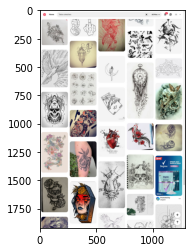

In [87]:
fetcher.screenshot()

In [89]:
fetcher.browser.find_element_by_css_selector("body").send_keys(Keys.HOME)

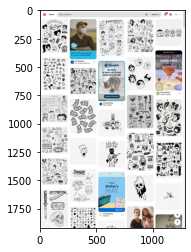

In [90]:
fetcher.screenshot()

In [ ]:
fetcher._homepage()

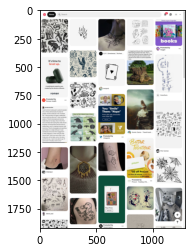

In [94]:
fetcher.screenshot()

In [95]:
fetcher.get_suggestions()

,label,link
0,Tattoo drawings,https://www.pinterest.nz/search/pins/?q=Tattoo...
1,Mini tattoos,https://www.pinterest.nz/search/pins/?q=Mini%2...
2,Garden design,https://www.pinterest.nz/search/pins/?q=Garden...
3,Black wallpaper,https://www.pinterest.nz/search/pins/?q=Black%...
4,Phone backgrounds,https://www.pinterest.nz/search/pins/?q=Phone%...
5,Bullet journal,https://www.pinterest.nz/search/pins/?q=Bullet...
6,Kitchen interior,https://www.pinterest.nz/search/pins/?q=Kitche...
7,Photo wall collage,https://www.pinterest.nz/search/pins/?q=Photo%...
8,Mothers day gifts,https://www.pinterest.nz/search/pins/?q=Mother...
9,Small bathroom ideas,https://www.pinterest.nz/search/pins/?q=Small%...
